In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
import torch

from juart.ellipsoid_phantoms.ellipsoids import SheppLogan
from juart.recon.ncgrappa import NonCartGrappa

# Create example data

In [ ]:
num_dims = 2
num_samples = 10
acc_factor = 1.5
img_size = (64, 64)
calib_size = (64, 30)
fov = (0.2, 0.2)  # Field of view in meters
kernel_size = (5, 5)  # Kernel size for gridding


# Create unsampled locations
x = np.linspace(-img_size[0] / 2, img_size[0] / 2, 9)
y = np.linspace(-img_size[1] / 2, img_size[1] / 2, 9)
xx, yy = np.meshgrid(x, y, indexing="ij")
grid_locations = np.stack([xx.ravel(), yy.ravel()], axis=0)

neighbor_locations = []
for loc in grid_locations.T:
    num_neighbors = np.random.randint(0, 5)  # Random number of neighbors
    neighbor_distances = np.random.uniform(
        -kernel_size[0] // 2, kernel_size[0] // 2, size=(2, num_neighbors)
    )
    neighbor_locations.append(loc[:, None] + neighbor_distances)
neighbor_locations = np.concatenate(neighbor_locations, axis=1)

grid_locations = torch.from_numpy(grid_locations)
grid_locations = torch.concatenate(
    (grid_locations, torch.zeros((1, grid_locations.shape[1]), dtype=torch.float32)),
    dim=0,
)

neighbor_locations = torch.from_numpy(neighbor_locations)
neighbor_locations = torch.concatenate(
    (
        neighbor_locations,
        torch.ones((1, neighbor_locations.shape[1]), dtype=torch.float32),
    ),
    dim=0,
)

# Concatenate only torch tensors
ktraj = torch.cat((grid_locations, neighbor_locations), dim=1)

sample_mask = ktraj[-1, :].bool()  # Last row is the sample mask

# Create a Shepp-Logan phantom
sl_phantom = SheppLogan(fov=fov, matrix=img_size)
sl_phantom.add_coil()
img = sl_phantom.get_object()
img = img[..., 0, 0]

kcalib = torch.fft.ifftshift(torch.fft.fft2(img, dim=(-1, -2, -3)))
start = img_size[1] // 2 - calib_size[1] // 2
end = -(img_size[1] // 2 - calib_size[1] // 2)
kcalib = kcalib[:, :, start:end]

print(f"Image shape: {img.shape}")

Image shape: torch.Size([8, 64, 64])


/tmp/ipykernel_95126/225205671.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(img.reshape(-1, img_size[1]).T), origin='lower', cmap='gray')
/tmp/ipykernel_95126/225205671.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.log(np.abs(np.reshape(kcalib, (-1, kcalib.shape[2]), order='C').T)), origin='lower', cmap='gray')


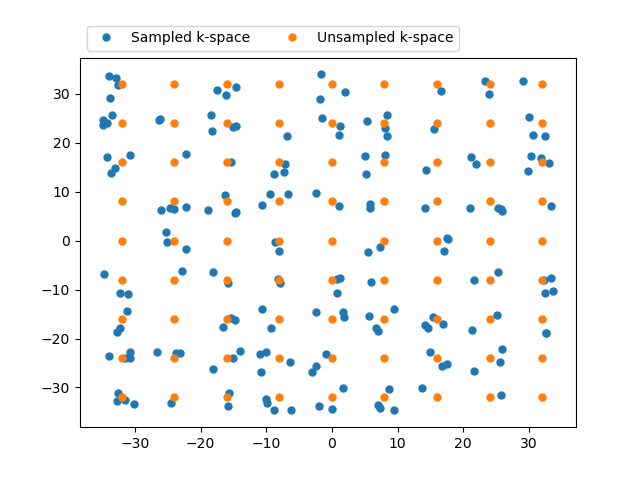

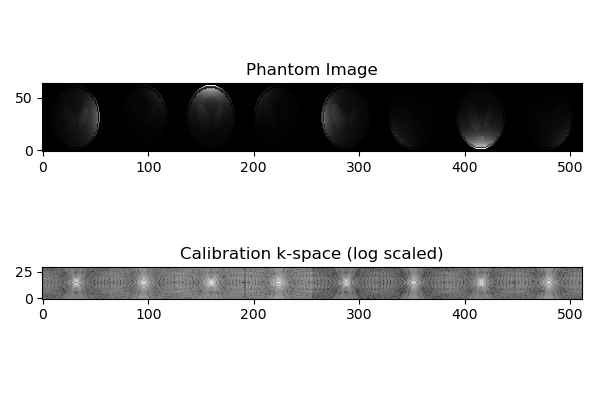

In [ ]:
plt.figure()
plt.plot(
    ktraj[0, sample_mask].numpy(),
    ktraj[1, sample_mask].numpy(),
    "o",
    markersize=5,
    label="Sampled k-space",
)
plt.plot(
    ktraj[0, ~sample_mask].numpy(),
    ktraj[1, ~sample_mask].numpy(),
    "o",
    markersize=5,
    label="Unsampled k-space",
)
plt.legend(loc="lower left", bbox_to_anchor=(0, 1), ncol=2)


plt.figure(figsize=(6, 4))

plt.subplot(
    2,
    1,
    1,
)
plt.imshow(np.abs(img.reshape(-1, img_size[1]).T), origin="lower", cmap="gray")
plt.title("Phantom Image")

plt.subplot(2, 1, 2)
plt.imshow(
    np.log(np.abs(np.reshape(kcalib, (-1, kcalib.shape[2]), order="C").T)),
    origin="lower",
    cmap="gray",
)
plt.title("Calibration k-space (log scaled)")
plt.tight_layout()

# Prepare Non Cartesian GRAPPA

In [ ]:
ktraj_scaled = ktraj.clone()
ktraj_scaled[:-1] /= torch.tensor(img_size)[:, None]
ncg = NonCartGrappa(
    ktraj=ktraj_scaled,
    calib_signal=kcalib,
    kernel_size=(7, 7),
    img_size=img_size,
)

/tmp/ipykernel_95126/3224100767.py:22: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  patch.center_loc[0]/norm_factor[0],
/tmp/ipykernel_95126/3224100767.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  patch.center_loc[1]/norm_factor[1],
/tmp/ipykernel_95126/3224100767.py:34: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  patch.neighbor_locs[0]/norm_factor[0],
/tmp/ipykernel_95126/3224100767.py:35: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  patch.neighbor_locs[1]/norm_factor[1],


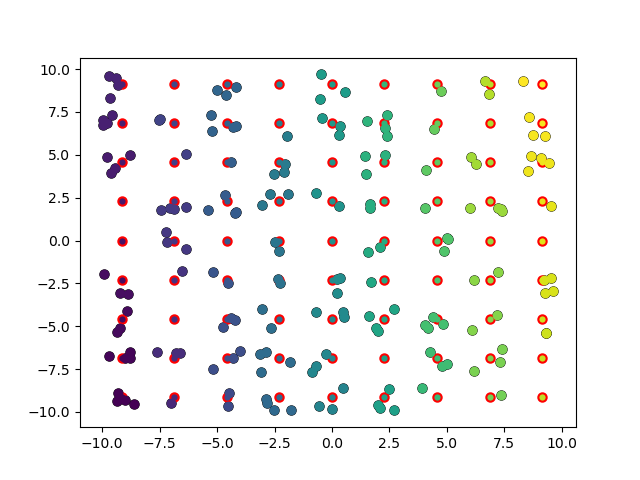

In [ ]:
plt.figure()
cmap = plt.cm.viridis
num_patches = len(ncg.patches)
norm_factor = ncg.kernel_size.numpy()[:, None] / 2

plt.plot(
    ncg.ktraj_sampled[0].numpy() / norm_factor[0],
    ncg.ktraj_sampled[1].numpy() / norm_factor[1],
    "o",
    markersize=6,
    markerfacecolor="none",
    markeredgecolor="black",
    markeredgewidth=1.5,
)

for patch in ncg.patches:
    # Use a different color for each patch from the viridis colormap
    patch_idx = ncg.patches.index(patch)
    color = cmap(patch_idx / max(num_patches - 1, 1))

    plt.plot(
        patch.center_loc[0] / norm_factor[0],
        patch.center_loc[1] / norm_factor[1],
        "o",
        markersize=6,
        color=color,
        markeredgecolor="red",
        markeredgewidth=1.5,
        label=f"Patch {patch_idx}"
        if patch_idx < 10
        else None,  # avoid too many legend entries
    )

    if patch.neighbor_locs is not None:
        plt.plot(
            patch.neighbor_locs[0] / norm_factor[0],
            patch.neighbor_locs[1] / norm_factor[1],
            "o",
            markersize=6,
            color=color,
        )